In [1]:

from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abhisekhbhagat","key":"64f8eff816fcb19176f696dfefb22723"}'}

In [2]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [3]:
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download meowmeowmeowmeowmeow/gtsrb-german-traffic-sign


Dataset URL: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
License(s): CC0-1.0
100% 609M/612M [00:29<00:00, 20.3MB/s]
100% 612M/612M [00:29<00:00, 21.8MB/s]


In [5]:
import zipfile
with zipfile.ZipFile("gtsrb-german-traffic-sign.zip", 'r') as zip_ref:
    zip_ref.extractall("gtsrb-dataset")

In [7]:
import os
import shutil
import random

def train_test_split_directory_sorted(source_dir, dest_dir, split_ratio=0.8):
    """
    Splits the dataset in source_dir into train and test sets in dest_dir based on the split_ratio.
    Processes subfolders in sorted order (e.g., 0, 1, ..., 42).
    Args:
        source_dir (str): Path to the source directory containing subfolders for each class.
        dest_dir (str): Path to the destination directory where 'train' and 'test' folders will be created.
        split_ratio (float): Proportion of data to include in the train set (default is 0.8).
    """
    # Create train and test directories
    train_dir = os.path.join(dest_dir, 'train')
    test_dir = os.path.join(dest_dir, 'test')
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Get sorted subfolder names
    subfolders = sorted(os.listdir(source_dir), key=lambda x: int(x) if x.isdigit() else x)

    # Iterate over each sorted class folder
    for class_name in subfolders:
        class_path = os.path.join(source_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        # Create corresponding class folders in train and test directories
        train_class_dir = os.path.join(train_dir, class_name)
        test_class_dir = os.path.join(test_dir, class_name)
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(test_class_dir, exist_ok=True)

        # Get all files in the current class folder
        files = os.listdir(class_path)
        random.shuffle(files)

        # Split files into train and test sets
        split_index = int(len(files) * split_ratio)
        train_files = files[:split_index]
        test_files = files[split_index:]

        # Copy files to train and test directories
        for file_name in train_files:
            shutil.copy(os.path.join(class_path, file_name), train_class_dir)
        for file_name in test_files:
            shutil.copy(os.path.join(class_path, file_name), test_class_dir)

        print(f"Class {class_name}: {len(train_files)} train, {len(test_files)} test")

# Example usage
source_directory = "/content/gtsrb-dataset/Train"  # Replace with your source directory
destination_directory = "/content/Dataset-german"  # Replace with your destination directory
train_test_split_directory_sorted(source_directory, destination_directory, split_ratio=0.8)


Class 0: 168 train, 42 test
Class 1: 1776 train, 444 test
Class 2: 1800 train, 450 test
Class 3: 1128 train, 282 test
Class 4: 1584 train, 396 test
Class 5: 1488 train, 372 test
Class 6: 336 train, 84 test
Class 7: 1152 train, 288 test
Class 8: 1128 train, 282 test
Class 9: 1176 train, 294 test
Class 10: 1608 train, 402 test
Class 11: 1056 train, 264 test
Class 12: 1680 train, 420 test
Class 13: 1728 train, 432 test
Class 14: 624 train, 156 test
Class 15: 504 train, 126 test
Class 16: 336 train, 84 test
Class 17: 888 train, 222 test
Class 18: 960 train, 240 test
Class 19: 168 train, 42 test
Class 20: 288 train, 72 test
Class 21: 264 train, 66 test
Class 22: 312 train, 78 test
Class 23: 408 train, 102 test
Class 24: 216 train, 54 test
Class 25: 1200 train, 300 test
Class 26: 480 train, 120 test
Class 27: 192 train, 48 test
Class 28: 432 train, 108 test
Class 29: 216 train, 54 test
Class 30: 360 train, 90 test
Class 31: 624 train, 156 test
Class 32: 192 train, 48 test
Class 33: 551 train

In [8]:
from torch import nn
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from  torch import optim
from torchvision import transforms, utils, models

from collections import OrderedDict
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [9]:
print(device)

cuda:0


In [10]:
data_dir = "/content/Dataset-german/"

train_transforms = transforms.Compose([
                                transforms.RandomRotation(30),
                                transforms.RandomHorizontalFlip(),
                                transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([
                                transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],
                                [0.229, 0.224, 0.225])])

train_data = datasets.ImageFolder(data_dir + 'train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + 'test', transform=test_transforms)

In [11]:
trainloader = torch.utils.data.DataLoader(dataset=train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(dataset=test_data, batch_size=64,shuffle=True)

In [13]:
model =  models.resnet18(pretrained=True).to(device)
#print(model)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 217MB/s]


In [14]:
import torch.nn.functional as F
from torch import nn

class Dc_model(nn.Module):
    def __init__(self):
        super().__init__()
        # Fully connected layers
        self.linear1 = nn.Linear(512, 256)
        self.linear2 = nn.Linear(256,43)

    def forward(self, x):
        # First layer with ReLU, batch norm, and dropout
        x = F.relu(self.linear1(x))
        x = self.linear2(x)

        return x


In [15]:
model_ = Dc_model().to(device)
model_

Dc_model(
  (linear1): Linear(in_features=512, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=43, bias=True)
)

In [16]:
model.fc = model_

Epoch 1/30


Training Loss: 0.0051, Accuracy: 0.8897


Validation Loss: 0.0022, Accuracy: 0.9546
Epoch 2/30


Training Loss: 0.0019, Accuracy: 0.9597


Validation Loss: 0.0010, Accuracy: 0.9753
Epoch 3/30


Training Loss: 0.0014, Accuracy: 0.9697


Validation Loss: 0.0014, Accuracy: 0.9723
Epoch 4/30


Training Loss: 0.0011, Accuracy: 0.9769


Validation Loss: 0.0012, Accuracy: 0.9770
Epoch 5/30


Training Loss: 0.0010, Accuracy: 0.9799


Validation Loss: 0.0057, Accuracy: 0.9319
Epoch 6/30


Training Loss: 0.0009, Accuracy: 0.9819


Validation Loss: 0.0004, Accuracy: 0.9915
Epoch 7/30


Training Loss: 0.0008, Accuracy: 0.9842


Validation Loss: 0.0008, Accuracy: 0.9828
Epoch 8/30


Training Loss: 0.0007, Accuracy: 0.9859


Validation Loss: 0.0003, Accuracy: 0.9927
Epoch 9/30


Training Loss: 0.0007, Accuracy: 0.9869


Validation Loss: 0.0004, Accuracy: 0.9922
Epoch 10/30


Training Loss: 0.0007, Accuracy: 0.9868


Validation Loss: 0.0003, Accuracy: 0.9944
Epoch 11/30


Training Loss: 0.0004, Accuracy: 0.9916


Validation Loss: 0.0002, Accuracy: 0.9964
Epoch 12/30


Training Loss: 0.0005, Accuracy: 0.9907


Validation Loss: 0.0004, Accuracy: 0.9920
Epoch 13/30


Training Loss: 0.0005, Accuracy: 0.9901


Validation Loss: 0.0004, Accuracy: 0.9936
Epoch 14/30


Training Loss: 0.0005, Accuracy: 0.9904


Validation Loss: 0.0004, Accuracy: 0.9920
Epoch 15/30


Training Loss: 0.0005, Accuracy: 0.9905


Validation Loss: 0.0003, Accuracy: 0.9931
Epoch 16/30


Training Loss: 0.0005, Accuracy: 0.9909


Validation Loss: 0.0001, Accuracy: 0.9973
Epoch 17/30


Training Loss: 0.0005, Accuracy: 0.9919


Validation Loss: 0.0004, Accuracy: 0.9934
Epoch 18/30


Training Loss: 0.0004, Accuracy: 0.9930


Validation Loss: 0.0003, Accuracy: 0.9944
Epoch 19/30


Training Loss: 0.0003, Accuracy: 0.9945


Validation Loss: 0.0001, Accuracy: 0.9973
Epoch 20/30


Training Loss: 0.0004, Accuracy: 0.9925


Validation Loss: 0.0003, Accuracy: 0.9944
Epoch 21/30


Training Loss: 0.0003, Accuracy: 0.9947


Validation Loss: 0.0004, Accuracy: 0.9936
Epoch 22/30


Training Loss: 0.0003, Accuracy: 0.9943


Validation Loss: 0.0003, Accuracy: 0.9940
Epoch 23/30


Training Loss: 0.0004, Accuracy: 0.9931


Validation Loss: 0.0001, Accuracy: 0.9981
Epoch 24/30


Training Loss: 0.0003, Accuracy: 0.9953


Validation Loss: 0.0006, Accuracy: 0.9908
Epoch 25/30


Training Loss: 0.0003, Accuracy: 0.9945


Validation Loss: 0.0002, Accuracy: 0.9977
Epoch 26/30


Training Loss: 0.0004, Accuracy: 0.9937


Validation Loss: 0.0001, Accuracy: 0.9981
Epoch 27/30


Training Loss: 0.0004, Accuracy: 0.9914


Validation Loss: 0.0002, Accuracy: 0.9964
Epoch 28/30


Training Loss: 0.0002, Accuracy: 0.9962


Validation Loss: 0.0001, Accuracy: 0.9982
Epoch 29/30


Training Loss: 0.0002, Accuracy: 0.9965


Validation Loss: 0.0001, Accuracy: 0.9981
Epoch 30/30


Training Loss: 0.0002, Accuracy: 0.9954


Validation Loss: 0.0001, Accuracy: 0.9973


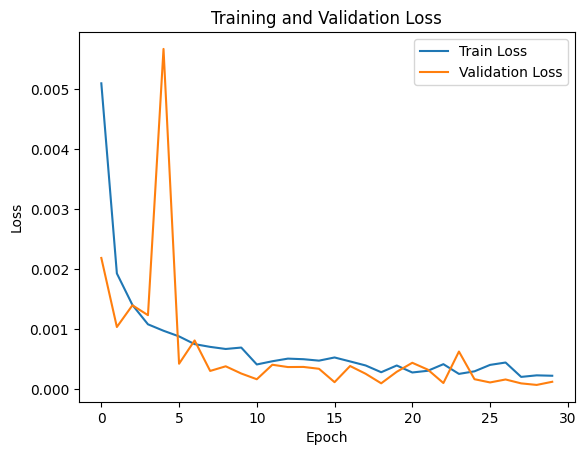

In [18]:
from tqdm import tqdm  # Progress bar library
import torch.optim as optim
import torch.nn as nn
import torch
import matplotlib.pyplot as plt

# Assuming `model`, `trainloader`, `testloader`, and `device` are already defined
for param in model.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

train_loss = []
val_loss = []

epochs = 30

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    # Training Phase
    model.train()
    running_loss = 0.0
    running_score = 0.0
    train_loop = tqdm(trainloader, desc="Training", leave=False)  # Training progress bar
    for image, label in train_loop:
        image = image.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        y_pred = model(image)
        loss = criterion(y_pred, label)
        loss.backward()  # Calculate derivatives
        optimizer.step()  # Update parameters

        val, index_ = torch.max(y_pred, axis=1)
        running_score += torch.sum(index_ == label.data).item()
        running_loss += loss.item()

        # Update progress bar
        train_loop.set_postfix(loss=loss.item(), accuracy=running_score / len(trainloader.dataset))

    epoch_score = running_score / len(trainloader.dataset)
    epoch_loss = running_loss / len(trainloader.dataset)
    train_loss.append(epoch_loss)
    print(f"Training Loss: {epoch_loss:.4f}, Accuracy: {epoch_score:.4f}")

    # Validation Phase
    model.eval()
    running_loss = 0.0
    running_score = 0.0
    val_loop = tqdm(testloader, desc="Validating", leave=False)  # Validation progress bar
    with torch.no_grad():
        for image, label in val_loop:
            image = image.to(device)
            label = label.to(device)

            y_pred = model(image)
            loss = criterion(y_pred, label)
            running_loss += loss.item()

            val, index_ = torch.max(y_pred, axis=1)
            running_score += torch.sum(index_ == label.data).item()

            # Update progress bar
            val_loop.set_postfix(loss=loss.item(), accuracy=running_score / len(testloader.dataset))

    epoch_score = running_score / len(testloader.dataset)
    epoch_loss = running_loss / len(testloader.dataset)
    val_loss.append(epoch_loss)
    print(f"Validation Loss: {epoch_loss:.4f}, Accuracy: {epoch_score:.4f}")

    # Learning rate adjustment
    #scheduler.step(epoch_loss)

# Plot Losses
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()


In [19]:
import torch

# Assuming `model` is your ResNet with unfrozen layers and custom FC layers
model_path = "resnet_custom_fc.pth"

# Save the model's state_dict (recommended)
torch.save(model.state_dict(), model_path)

print(f"Model saved to {model_path}")


Model saved to resnet_custom_fc.pth
